<a href="https://colab.research.google.com/github/bharatnishant/Federated/blob/master/IDS_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Data Pre-Processing

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

In [0]:
!pip install syft

In [0]:
#creating virtual workers
import syft as sy  
hook = sy.TorchHook(torch)  
ted = sy.VirtualWorker(hook, id="ted")  
med = sy.VirtualWorker(hook, id="med") 

W0819 18:09:33.122921 140280796088192 hook.py:98] Torch was already hooked... skipping hooking process


In [0]:
df = pd.read_csv('Train_1.txt', sep = ',', names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"])

df_test = pd.read_csv('Test_1.txt', sep = ',', names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"])

In [0]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,intrusion,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [0]:
df.groupby(['protocol_type']).describe()


duration                                ... last_flag                  
                  count        mean          std  min  ...       25%   50%   75%   max
protocol_type                                          ...                            
icmp             8291.0    0.000000     0.000000  0.0  ...      16.0  17.0  18.0  21.0
tcp            102689.0  281.386419  2776.679452  0.0  ...      19.0  21.0  21.0  21.0
udp             14993.0  485.372040  2025.973457  0.0  ...      18.0  18.0  21.0  21.0

[3 rows x 312 columns]

In [0]:
df_test.groupby(['attack']).describe()

duration                                ... last_flag                  
                   count        mean          std  min  ...       25%   50%   75%   max
attack                                                  ...                            
iintrusionweep     141.0    0.000000     0.000000  0.0  ...      16.0  17.0  18.0  18.0
intrusion        12690.0  352.787864  1545.542527  0.0  ...      14.0  18.0  20.0  21.0
normal            9711.0   47.068376  1192.455478  0.0  ...      21.0  21.0  21.0  21.0
udintrusiontorm      2.0    0.000000     0.000000  0.0  ...      11.0  13.0  15.0  17.0

[4 rows x 312 columns]

In [0]:
df.loc[df['protocol_type'] == 'icmp', "protocol_type"] = 3
df.loc[df['protocol_type'] == 'tcp', "protocol_type"] = 1
df.loc[df['protocol_type'] == 'udp', "protocol_type"] = 2

In [0]:
df_test.loc[df_test['protocol_type'] == 'icmp', "protocol_type"] = 3
df_test.loc[df_test['protocol_type'] == 'tcp', "protocol_type"] = 1
df_test.loc[df_test['protocol_type'] == 'udp', "protocol_type"] = 2

In [0]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,1,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,2,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,1,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,intrusion,19
3,0,1,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,1,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [0]:
df_test.groupby(['service']).describe()

duration                                  ... last_flag                   
               count         mean           std  min  ...       25%   50%    75%   max
service                                               ...                             
IRC             13.0  4248.538462   2924.972553  0.0  ...     18.00  20.0  20.00  20.0
X11             15.0  6217.466667  15478.810996  0.0  ...      2.00   4.0   9.50  19.0
Z39_50          45.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  20.0
auth            67.0     0.044776      0.271519  0.0  ...     18.00  19.0  20.50  21.0
bgp             46.0     0.000000      0.000000  0.0  ...     18.00  19.0  19.00  21.0
courier         40.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  21.0
csnet_ns        34.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
ctf             41.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
daytime         28.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
discard         26.0     0.000000      0.000000  0.0  ...     19.00  19.5  20.00  21.0
domain          51.0    49.137255    199.745440  0.0  ...     19.00  19.0  20.00  21.0
domain_u       894.0     4.579418    124.025057  0.0  ...     18.00  18.0  21.00  21.0
echo            37.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  21.0
eco_i          262.0     0.000000      0.000000  0.0  ...     15.00  16.0  18.00  21.0
ecr_i          752.0     0.000000      0.000000  0.0  ...     18.00  18.0  19.00  21.0
efs             33.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
exec            27.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  21.0
finger         136.0     0.022059      0.147418  0.0  ...     18.00  20.0  21.00  21.0
ftp            692.0   205.715318    125.867392  0.0  ...     11.00  12.0  14.00  21.0
ftp_data       851.0    72.985899    122.796033  0.0  ...     13.00  17.0  20.00  21.0
gopher          34.0     0.000000      0.000000  0.0  ...     18.25  20.0  20.00  21.0
hostnames       23.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  21.0
http          7853.0    74.973131    320.095431  0.0  ...     21.00  21.0  21.00  21.0
http_443        36.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  21.0
intrusion4     306.0     0.950980      5.381896  0.0  ...     13.00  14.0  18.00  21.0
iso_tsap        48.0     0.000000      0.000000  0.0  ...     18.00  19.0  20.00  21.0
klogin          21.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
kshell          24.0     0.000000      0.000000  0.0  ...     19.00  20.0  21.00  21.0
ldap            19.0     0.000000      0.000000  0.0  ...     18.50  20.0  20.00  21.0
link            41.0     0.073171      0.468521  0.0  ...     18.00  20.0  20.00  21.0
...              ...          ...           ...  ...  ...       ...   ...    ...   ...
netbios_ns      36.0     0.000000      0.000000  0.0  ...     19.00  20.0  21.00  21.0
netbios_ssn     15.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
netstat         26.0     0.000000      0.000000  0.0  ...     19.00  20.0  21.00  21.0
nnsp            42.0     0.000000      0.000000  0.0  ...     19.00  20.0  20.00  21.0
nntp            21.0     0.238095      1.091089  0.0  ...     18.00  20.0  21.00  21.0
ntp_u           10.0     0.000000      0.000000  0.0  ...     21.00  21.0  21.00  21.0
other          838.0    59.151551    779.036756  0.0  ...     17.00  18.0  20.00  21.0
pm_dump         16.0     0.000000      0.000000  0.0  ...      4.75   5.0   5.25   6.0
pop_2           13.0     0.000000      0.000000  0.0  ...     21.00  21.0  21.00  21.0
pop_3         1019.0     3.206084      2.151602  0.0  ...     11.00  15.0  18.00  21.0
printer         11.0     0.000000      0.000000  0.0  ...     21.00  21.0  21.00  21.0
private       4774.0     0.050691      2.973792  0.0  ...     17.00  21.0  21.00  21.0
remote_job

In [0]:
df = df.drop('service', axis = 1)
df_test = df_test.drop('service', axis = 1)

In [0]:
df.groupby(['flag']).describe()


duration                                   ... last_flag                  
          count          mean           std  min  ...       25%   50%   75%   max
flag                                              ...                            
OTH        46.0      0.000000      0.000000  0.0  ...      11.0  12.0  14.0  20.0
REJ     11233.0      0.020475      0.377342  0.0  ...      19.0  20.0  21.0  21.0
RSTO     1562.0    163.108835   1643.879376  0.0  ...      18.0  20.0  20.0  21.0
RSTOS0    103.0   3407.174757  10500.314823  1.0  ...      20.0  20.0  20.0  21.0
RSTR     2421.0  10333.520446  14200.957342  0.0  ...      15.0  15.0  18.0  21.0
S0      34851.0      0.000000      0.000000  0.0  ...      18.0  20.0  21.0  21.0
S1        365.0      0.000000      0.000000  0.0  ...      14.0  18.0  18.0  21.0
S2        127.0      7.511811     42.143531  0.0  ...      17.0  18.0  18.0  20.0
S3         49.0    438.755102   1916.306849  0.0  ...      13.0  14.0  17.0  18.0
SF      74945.0    140.457963   1155.123553  0.0  ...      19.0  21.0  21.0  21.0
SH        271.0      0.000000      0.000000  0.0  ...      18.0  18.0  18.0  21.0

[11 rows x 320 columns]

In [0]:
df.loc[df['flag'] == 'REJ', "flag"] = 1
df.loc[df['flag'] == 'SF', "flag"] = 2
df.loc[df['flag'] == 'S0', "flag"] = 3
df.loc[df['flag'] == 'RSTR', "flag"] = 4
df.loc[df['flag'] == 'RSTOS0', "flag"] = 5
df.loc[df['flag'] == 'RSTO', "flag"] = 6
df.loc[df['flag'] == 'SH', "flag"] = 7
df.loc[df['flag'] == 'S1', "flag"] = 8
df.loc[df['flag'] == 'S2', "flag"] = 9
df.loc[df['flag'] == 'S3', "flag"] = 10
df.loc[df['flag'] == 'OTH', "flag"] = 11

In [0]:
df_test.loc[df_test['flag'] == 'REJ', "flag"] = 1
df_test.loc[df_test['flag'] == 'SF', "flag"] = 2
df_test.loc[df_test['flag'] == 'S0', "flag"] = 3
df_test.loc[df_test['flag'] == 'RSTR', "flag"] = 4
df_test.loc[df_test['flag'] == 'RSTOS0', "flag"] = 5
df_test.loc[df_test['flag'] == 'RSTO', "flag"] = 6
df_test.loc[df_test['flag'] == 'SH', "flag"] = 7
df_test.loc[df_test['flag'] == 'S1', "flag"] = 8
df_test.loc[df_test['flag'] == 'S2', "flag"] = 9
df_test.loc[df_test['flag'] == 'S3', "flag"] = 10
df_test.loc[df_test['flag'] == 'OTH', "flag"] = 11

In [0]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,1,2,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,2,2,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,intrusion,19
3,0,1,2,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,1,2,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [0]:
df.groupby(['attack']).describe()

duration                                ... last_flag                  
             count        mean          std  min  ...       25%   50%   75%   max
attack                                            ...                            
intrusion  58630.0  423.320689  3547.684533  0.0  ...      18.0  19.0  20.0  21.0
normal     67343.0  168.587396  1304.452127  0.0  ...      20.0  21.0  21.0  21.0

[2 rows x 328 columns]

In [0]:
df.loc[df['attack'] == 'normal',"attack"] = 1
df.loc[df['attack'] == 'intrusion',"attack"] = 0

In [0]:
df_test.loc[df_test['attack'] == 'normal',"attack"] = 1
df_test.loc[df_test['attack'] == 'intrusion',"attack"] = 0
df_test.loc[df_test['attack'] == 'iintrusionweep',"attack"] = 0
df_test.loc[df_test['attack'] == 'udintrusiontorm',"attack"] = 0

In [0]:
df_test_nb = df_test
df_train_nb = df

In [0]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,1,2,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1,20
1,0,2,2,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1,15
2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,19
3,0,1,2,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,21
4,0,1,2,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,21


In [0]:
df_x = df.drop('attack', axis = 1)
df_y = df['attack']

In [0]:
df_x_test = df_test.drop('attack', axis = 1)
df_y_test = df_test['attack']

In [0]:
scaler = StandardScaler()
df_x_scaled = pd.DataFrame(scaler.fit_transform(df_x))
df_x_test_scaled = pd.DataFrame(scaler.fit_transform(df_x_test))

In [0]:
df_y.head()

0    1
1    1
2    0
3    1
4    1
Name: attack, dtype: int64

In [0]:
df_x_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,-0.110249,-0.443466,-0.355453,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002817,-0.097531,-0.717045,-0.354343,-0.637209,-0.631929,-0.374362,-0.374432,0.771283,-0.349683,-0.374560,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0.216426
1,-0.110249,1.325807,-0.355453,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002817,-0.097531,-0.620982,-0.368110,-0.637209,-0.631929,-0.374362,-0.374432,-1.321428,0.482201,-0.374560,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,-1.965556
2,-0.110249,-0.443466,0.756836,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002817,-0.097531,0.339648,-0.299273,1.602664,1.605104,-0.374362,-0.374432,-1.389669,0.038529,-0.374560,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,-0.219970
3,-0.110249,-0.443466,-0.355453,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002817,-0.097531,-0.690846,-0.313041,-0.189235,-0.184522,-0.374362,-0.374432,0.771283,-0.349683,-0.374560,-1.533670,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,0.652823
4,-0.110249,-0.443466,-0.355453,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002817,-0.097531,-0.472521,0.058678,-0.637209,-0.631929,-0.374362,-0.374432,0.771283,-0.349683,-0.028179,0.734343,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.652823


In [0]:
df_x_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,-0.155534,-0.411275,-0.932969,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,-0.022095,-0.171071,1.166764,-0.237191,-0.348468,-0.347390,1.830141,1.837604,-1.697859,-0.131492,-0.386963,0.650093,-1.169697,-1.305370,-0.138370,-0.431856,-0.229980,-0.358118,-0.35275,1.979791,1.929116,0.698325
1,-0.155534,-0.411275,-0.932969,-0.021988,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,-0.022095,-0.171071,0.443234,-0.338246,-0.348468,-0.347390,1.830141,1.837604,-1.770589,-0.131492,-0.386963,0.650093,-1.250212,-1.397181,-0.138370,-0.431856,-0.229980,-0.358118,-0.35275,1.979791,1.929116,0.698325
2,-0.154113,-0.411275,-0.175492,0.005473,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,-0.022095,-0.171071,-0.607053,-0.338246,-0.348468,-0.347390,-0.573079,-0.565054,0.629488,-0.363035,-0.386963,-0.636681,-0.489800,0.002934,-0.228985,1.559906,0.004234,-0.358118,-0.35275,-0.602719,-0.565483,0.698325
3,-0.155534,3.528299,-0.175492,-0.021946,-0.096896,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,-0.022095,-0.171071,-0.607053,0.380366,-0.348468,-0.347390,-0.573079,-0.565054,0.629488,-0.363035,3.557193,-2.029801,-0.749234,0.898090,-0.410217,2.833328,3.049016,-0.358118,-0.35275,-0.602719,-0.565483,-0.706739
4,-0.154823,-0.411275,2.854415,-0.021988,-0.096189,-0.017624,-0.059104,-0.019459,-0.113521,-0.143999,-0.890373,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,-0.022095,-0.171071,-0.607053,-0.259648,-0.348468,0.054856,1.830141,0.636275,0.629488,-0.363035,2.571154,-1.753304,-0.489800,-0.685647,0.360018,-0.333901,0.004234,-0.358118,-0.35275,1.540764,1.205682,-1.643449


In [0]:
df_tensor = torch.tensor(df_x_scaled.values, requires_grad=True).type(torch.FloatTensor)
df_tensor_y = torch.tensor(df_y)

In [0]:
df_tensor_test = torch.tensor(df_x_test_scaled.values, requires_grad=True).type(torch.FloatTensor)
df_tensor_y_test = torch.tensor(df_y_test.values).type(torch.FloatTensor)

In [0]:
type(df_tensor)
df_tensor

tensor([[-0.1102, -0.4435, -0.3555,  ..., -0.2245, -0.3764,  0.2164],
        [-0.1102,  1.3258, -0.3555,  ..., -0.3876, -0.3764, -1.9656],
        [-0.1102, -0.4435,  0.7568,  ..., -0.3876, -0.3764, -0.2200],
        ...,
        [-0.1102, -0.4435, -0.3555,  ..., -0.3550, -0.3764, -0.6564],
        [-0.1102, -0.4435,  0.7568,  ..., -0.3876, -0.3764,  0.2164],
        [-0.1102, -0.4435, -0.3555,  ..., -0.3876, -0.3764,  0.6528]],
       grad_fn=<CopyBackwards>)

In [0]:
df_tensor_test

tensor([[-0.1555, -0.4113, -0.9330,  ...,  1.9798,  1.9291,  0.6983],
        [-0.1555, -0.4113, -0.9330,  ...,  1.9798,  1.9291,  0.6983],
        [-0.1541, -0.4113, -0.1755,  ..., -0.6027, -0.5655,  0.6983],
        ...,
        [-0.1555, -0.4113, -0.1755,  ..., -0.4219, -0.3909, -0.7067],
        [-0.1555,  1.5585, -0.1755,  ..., -0.6027, -0.5655,  0.6983],
        [-0.1555, -0.4113, -0.9330,  ...,  0.5336,  1.9291, -0.9409]],
       grad_fn=<CopyBackwards>)

In [0]:
df_tensor_y

tensor([1, 1, 0,  ..., 1, 0, 1])

In [0]:
np.shape(df_tensor)

torch.Size([125973, 41])

In [0]:
'''
train_idx = int(len(df_x)/2)
test_idx = int(len(df_x_test)/2)

# Sending toy datasets to virtual workers
ted_train_dataset = sy.BaseDataset(df_tensor[:train_idx], 
                                  df_tensor_y[:train_idx]).send(ted)
med_train_dataset = sy.BaseDataset(df_tensor[train_idx:], 
                                    df_tensor_y[train_idx:]).send(med)
ted_test_dataset = sy.BaseDataset(df_tensor_test[:test_idx], 
                                  df_tensor_y_test[:test_idx]).send(ted)
med_test_dataset = sy.BaseDataset(df_tensor_test[test_idx:], 
                                  df_tensor_y_test[test_idx:]).send(med)
'''

#Model

In [0]:
model = nn.Sequential(nn.Linear(41, 256),
                      nn.ReLU(),
                      nn.Linear(256,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,2),
                      nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=41, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=2, bias=True)
  (7): Sigmoid()
)

In [0]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum  = 1.0)

criterion = nn.NLLLoss()

In [0]:
'''
federated_train_dataset = sy.FederatedDataset([ted_train_dataset, med_train_dataset])
federated_test_dataset = sy.FederatedDataset([ted_test_dataset, med_test_dataset])

# Creating federated dataloaders, an extension of Pytorch DataLoader class
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, 
                                                shuffle=True)
federated_test_loader = sy.FederatedDataLoader(federated_test_dataset,
                                               shuffle=False)
'''

#Federated Training

Tried Federated Learning approach but couldn't apply federated learning. With more research will be able to add federated learning sometimes later.

In [0]:
'''
epochs = 200
i=0
training_loss = []
for e in range(epochs):
    
    
    
    losses = []
   
    for inputs, labels in federated_train_loader:
       
        worker = inputs.location
        
        model.send(worker)
        
        optimizer.zero_grad()
        
        output = model(inputs)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
       
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        
        optimizer.step() 
      
        model.get()
        losses.append(loss.get())
        
        print(f"Training loss: {loss/len(df_tensor_y)}  ", i)
        '''

#Training

In [0]:
epochs = 200
i=0
training_loss = []
for e in range(epochs):
  running_loss = 0
  i=i+1
  optimizer.zero_grad()
  output = model.forward(df_tensor.type(torch.FloatTensor))
  
  
  loss = criterion(output, df_tensor_y)

  loss.backward()
  optimizer.step()
        
    
  running_loss += loss.item()
  
  training_loss.append(running_loss)
  print(f"Training loss: {running_loss/len(df_tensor_y)}  ", i)

Training loss: -4.187275385211814e-06   1
Training loss: -4.1876931803054985e-06   2
Training loss: -4.188538706729523e-06   3
Training loss: -4.189926467782496e-06   4
Training loss: -4.192206597518015e-06   5
Training loss: -4.194158358289756e-06   6
Training loss: -4.196579014800841e-06   7
Training loss: -4.1994520066568435e-06   8
Training loss: -4.202675605720569e-06   9
Training loss: -4.206363842136501e-06   10
Training loss: -4.210530910528433e-06   11
Training loss: -4.215344780611267e-06   12
Training loss: -4.220415100230654e-06   13
Training loss: -4.226437879106651e-06   14
Training loss: -4.232185282281035e-06   15
Training loss: -4.238417195280937e-06   16
Training loss: -4.245382024022761e-06   17
Training loss: -4.252690362660411e-06   18
Training loss: -4.260660170766883e-06   19
Training loss: -4.268202247543016e-06   20
Training loss: -4.276749303683797e-06   21
Training loss: -4.285792225349132e-06   22
Training loss: -4.295535888275788e-06   23
Training loss: -4.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
[-0.5274836421012878, -0.5275362730026245, -0.5276427865028381, -0.5278176069259644, -0.528104841709137, -0.5

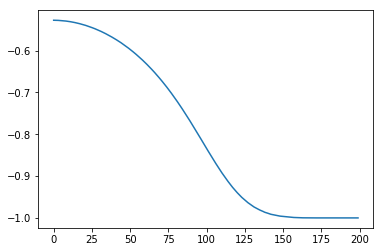

In [0]:
epoch_x = [x for x in range(epochs)]

print(epoch_x)
print(training_loss)
plt.plot(epoch_x,training_loss)

plt.show()

#Test and Accuracy

In [0]:
test_output = model.forward(df_tensor_test)
 
outputu = []

In [0]:
for a in test_output:
  if a[0] >= a[1]:
    outputu.append(0)
  else:
    outputu.append(1)

In [0]:
(test_output.type(torch.FloatTensor)).mean()

tensor(1.0000, grad_fn=<MeanBackward0>)

In [0]:
count = 0

df_tensor_y_test = df_tensor_y_test .type(torch.ByteTensor)
for out, act in zip(outputu, df_tensor_y_test):
  if out == act:
    count += 1


print("accuracy_score:", (count/len(df_tensor_y_test))*100)


accuracy_score: 82.89567068843151
